<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/A_journey_of_predicting_future_sales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows a routine of using machine learning to solve problems. Following topics are covered:
1. data preprocessing
2. data manipulating 
3. building models
4. fine-tuning and improve models.

# Data preprocessing 
When working with machine learning, for most of the time, we're dealing with data cleaning, exploring and merging. Building models and fine-tuning parameters, on the other hand, has been much easier with so many popular libraries, e.g., `Sklearn`, `Tensorflow` and `Pytorch`.

<!-- Data preprocessing is very important -->

In this notebook, we will take the following task [predict future sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/notebooks) as an example, to show how to precess data to comply with our needs.

In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import sklearn.metrics 
import sklearn.model_selection
import sklearn.feature_extraction
import sklearn.preprocessing

from absl import logging
import gensim.downloader as api
import matplotlib.pyplot as plt
logging.set_verbosity(logging.INFO)

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## File description. 

There are 6 files for this specific task:
1. `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.
2. `test.csv` - the test set. You need to forecast the sales for these shops and products for November 2015.
3. `sample_submission.csv` - a sample submission file in the correct format.
4. `items.csv` - supplemental information about the items/products.
5. `item_categories.csv`  - supplemental information about the items categories.
6. `shops.csv` - supplemental information about the shops.

In [2]:
!curl -o sales.zip ali.140714.xyz:8000/sales.zip
!unzip sales.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.7M  100 14.7M    0     0  2977k      0  0:00:05  0:00:05 --:--:-- 3802k
Archive:  sales.zip
   creating: data/
  inflating: data/sales_train.csv    
  inflating: data/shops.csv          
  inflating: data/test.csv           
  inflating: data/item_categories.csv  
  inflating: data/items.csv          
  inflating: data/sample_submission.csv  
data  sales.zip  sample_data


We craft several methods to explore the data.

In [0]:
def birdview(data):
    print("----------Head 5 Record----------")
    print(data.head(5))
    print("\n-----------Information-----------")
    print(data.info())
    print("\n-----------Data Types-----------")
    print(data.dtypes)
    print("\n----------Missing value-----------")
    print(data.isnull().sum())
    print("\n----------Null value-----------")
    print(data.isna().sum())
    print("\n----------Shape of Data----------")
    print(data.shape)
    
def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);

def distribution_insight(data, column):
    print("===================================")
    print("Min Value:", data[column].min())
    print("Max Value:", data[column].max())
    print("Average Value:", data[column].mean())
    print("Center Point of Data (median):", data[column].median())
    print("===================================")
    # sns.boxplot(data[column])
    
def remove_duplicate(data):
    print('Before remove shape:', data.shape)
    before = data.shape[0]
    # subset is list where you have to put all column for duplicate check
    # if None, then use all columns 
    data.drop_duplicates(subset=None, keep='first', inplace=True) 
    data.reset_index(drop=True, inplace=True)
    print('After remove shape :', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)    

## Explore `train.csv`
First, let's find out what we have in this **train** file, is there any missing, duplicate value?. If so, we will dealing with it by: 
* removing duplicates
* removing or replacing outliers, e.g., negative daily sale counts
* 

In [4]:
train = pd.read_csv('data/sales_train.csv')
birdview(train)

----------Head 5 Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

-----------Data Types-----------
date               object
date_block_num

A birdview of `train.csv`, we found that:
1. There are outliers, e.g., the 3rd row has a negative `item_cnt_day`
2. There is no missing value or Null value, which is good.

Now, we run `remove_duplicate()` method to remove potential duplicate rows. 

In [5]:
remove_duplicate(train)

Before remove shape: (2935849, 6)
After remove shape : (2935843, 6)
Total Duplicate: 6


We found and removed 6 duplicated rows, not a big deal since we still got 2_935_843 unique rows. 

Next, we need to deal with outliers. A natual way is drawing its distribution graph and see whether this distribution comply with our intuition. 

We've also wrote a method `distribution_insight()` to gain insights on `int | float` datatype columns.

{dtype('float64'), dtype('int64'), dtype('O')}
date_block_num
Min Value: 0
Max Value: 33
Average Value: 14.569912628161656
Center Point of Data (median): 14.0
item_id
Min Value: 0
Max Value: 22169
Average Value: 10197.229012927462
Center Point of Data (median): 9343.0
shop_id
Min Value: 0
Max Value: 59
Average Value: 33.001713306876425
Center Point of Data (median): 31.0
item_cnt_day
Min Value: -22.0
Max Value: 2169.0
Average Value: 1.2426413810275276
Center Point of Data (median): 1.0
item_price
Min Value: -1.0
Max Value: 307980.0
Average Value: 890.8534715116427
Center Point of Data (median): 399.0


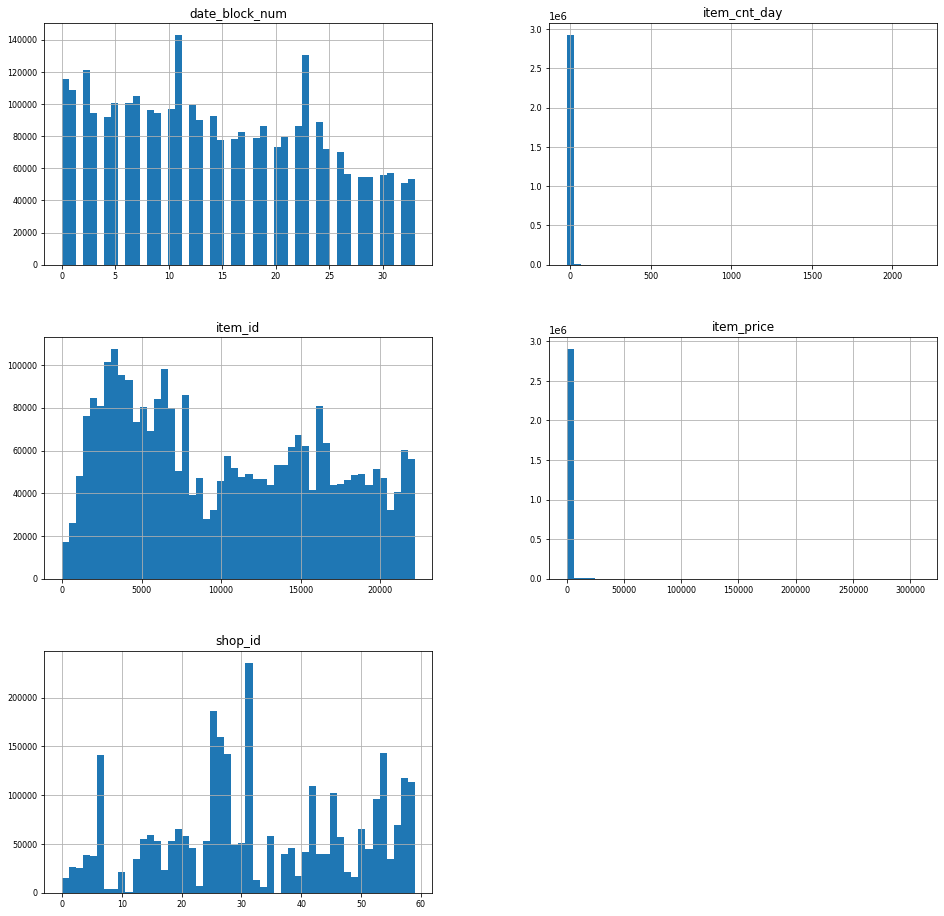

In [6]:
graph_insight(train)
for col in ('date_block_num', 'item_id', 'shop_id', 'item_cnt_day', 'item_price'):
    print(col)
    distribution_insight(train, col)

## Data cleaning 
Dealing with outlier, fill out those empty values, etc. 

There are negative `item_cnt_day` and negative `item_price`, this can not be right. 

Let's deal with negative `item_price` first. 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,15.05.2013,4,32,2973,-1.0,1.0


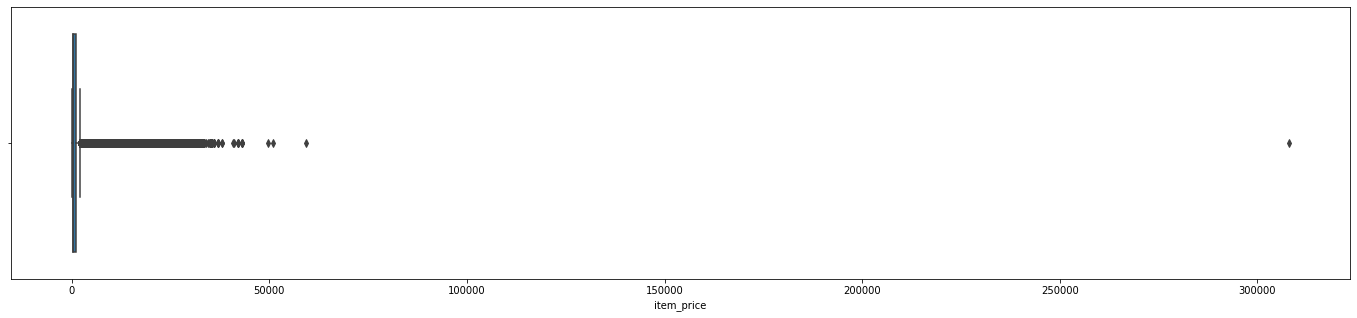

In [7]:
plt.figure(figsize=(24, 5))
sns.boxplot(train['item_price'])
train[train.item_price <= 0]

There is one row with -1.0 `item_price`, and its `item_id` is 2973. 

By filtering on the samee `item_id` and `date_block_num` (same month): `train[(train.item_id == 2973) & (train.date_block_num == 4)]`, we found that most price during this month is `1249`. So we're going to replace it with `1249`. 

Also, there is an outlier with very large `item_price`: 307980, we simply remove it from dataset

In [8]:
train.loc[train.item_price < 0, 'item_price'] = 1249

train = train[train.item_price < 100_000]
train[train.item_price >= 100_000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


We're done with the `item_price` feature, now we need to fix `item_cnt_day`. 

This problem is a little bit more serious, since we got 7356 rows with negative `item_cnt_day`. Most of them has `-1` as the value. Potential strategies:
1. replace each negative value by its absolution value (maybe caused by writing mistakes)
2. remove them 
3. replace with most frequent `item_cn_day` with same `item_id`

For simplity, we remove those rows.

In [0]:
train[train.item_cnt_day < 0].shop_id.value_counts()
# train[(train.item_cnt_day < 0) & (train.shop_id == 25)]
train[(train.date_block_num == 1) & (train.shop_id == 12)].item_cnt_day.value_counts()
train = train[train.item_cnt_day >= 0]

Some Russian speakers found mislabel on shop ids.
So we correct them in train and test set.

In [0]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10
# РостовНаДону ТРК "Мегацентр Горизонт" Островной
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

Now we're done with data cleaning, the next step is tailoring (is this a word) our data so we can build a model and run on it.

# Data manipulating

In [0]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats  = pd.read_csv('data/item_categories.csv')
test  = pd.read_csv('data/test.csv').set_index('ID')

Observations (by some Russian speakers):

1. Each shop_name starts with the city name.
2. Each category contains type and subtype in its name.

The following codes deal with 
1. `shop_name` (in Russian) from dataset `shops` by extracting the city name from it and label encoding it to numbers
2. `item_category_name` from dataset `cats` by spliting it into `main_type` and `sub_type` and label encoding them
3. dropping `item_name` from dataset `items`

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Categorize shop names

In [25]:
shops_df = shops 
shops_df.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops_df['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df['category'] = shops['shop_name'].str.split(' ').map(lambda x: x[1]).astype(str)
shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'

top_cats = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops_df['category'] = shops_df.category.apply(lambda x: x if x in top_cats else 'etc')

shops_df['shop_city'] = sklearn.preprocessing.LabelEncoder().fit_transform(shops_df['city'])
shops_df['shop_category'] = sklearn.preprocessing.LabelEncoder().fit_transform(shops_df['category'])
shops_df = shops_df[['shop_id','shop_city', 'shop_category']]

shops_df.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


Categorize cats info

In [34]:
cats_df = cats 
cats_df['type_code'] = cats_df.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
# Fuse some item_category_name 
cats_df.loc[(cats_df.type_code == 'Игровые') | (cats_df.type_code == 'Аксессуары'), 'type_code'] = 'Игры'
cats_df.loc[cats_df.type_code == 'PC', 'type_code'] = 'Музыка'

top_type_codes = set(['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые'])
cats_df['type_code'] = cats_df.type_code.apply(lambda t: t if t in top_type_codes else 'etc')
cats_df['type_code'] = sklearn.preprocessing.LabelEncoder().fit_transform(cats_df['type_code'])

## Labelencoder item_category_name (sub category) to subtype_code
cats_df['split'] = cats_df.item_category_name.apply(lambda x: x.split('-'))
cats_df['subtype'] = cats_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats_df['subtype_code'] = sklearn.preprocessing.LabelEncoder().fit_transform(cats_df['subtype'])

cats_df = cats_df[['item_category_id','type_code', 'subtype_code']]
cats_df.head()
# cats_df.type_code.value_counts()

,item_category_id,type_code,subtype_code
0,0,5,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


Categorize item info

In [152]:
import collections
import operator 

items_df = items
items_df['item_name'] = items_df.item_name.str.strip() # removing leading / trailing whitespaces, essential for later steps

items_df['name_1'], items_df['name_2'] = items_df['item_name'].str.split('[', 1).str
items_df['name_1'], items_df['name_3'] = items_df['item_name'].str.split('(', 1).str

# Replace non-alphabatic symbols by ' '
items_df['name_2'] = items_df['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower().str.strip()
items_df['name_3'] = items_df['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower().str.strip()
items_df.fillna('0', inplace=True)
items_df.loc[items_df.name_2 == '', 'name_2'] = '0' # two of those '' can not be filled by '0', weird

# Experiments ?
# cnt = collections.Counter(' '.join(items_df['name_2'].values.tolist()).split(' ')).items()
# cnt = sorted(cnt, key=operator.itemgetter(1))
# items_df.sample(10)
# cnt

items_df['type'] = items_df.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items_df.loc[(items_df.type == 'x360') | (items_df.type == 'xbox360'), 'type'] = 'xbox 360'
items_df.loc[items_df.type == 'рs3', 'type'] = 'ps3' # beware, 'рs3' is not English string 'ps3'
items_df.loc[(items_df.type == 'pс') | (items_df.type == 'рс'), 'type'] = 'pc' 


items_df[items_df.name_2 == '']
# items_df[(items_df.name_2.str.contains('pc цифровая версия'))].sample(10)
droplists = set([k for k, v in items_df.type.value_counts().items() if v < 20])
droplists
# 
# Replece low frequence item type by other in name_2
items_df['name_2'] = items.type.apply(lambda n: 'other' if n in droplists else n)
# items_df['name_2'] = sklearn.preprocessing.LabelEncoder().fit_transform(items_df.name_2)
items_df.name_3.value_counts()
# type_cnt = items_df.groupby('type').sum()
# type_cnt

# drop_list = type_cnt.loc[type_cnt.item_category_id < 200].index
# drop_list

# items_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


0                                                      12854
регион                                                  1731
bd                                                      1644
фирм                                                     753
mp3 cd jewel                                             476
                                                       ...  
3 е издание pc цифровая версия                             1
сб м ф регион                                              1
120 gb black rus cech 2008a                                1
30см                                                       1
mag ii gun controller all interactive entertainment        1
Name: name_3, Length: 1658, dtype: int64

In [142]:
items_df.type.value_counts()
items_df[items_df.type == 'mac']

,item_name,item_id,item_category_id,name_1,name_2,name_3,type
1159,ABBYY FineReader Pro для Mac Full (версия для ...,1159,74,ABBYY FineReader Pro для Mac Full,mac цифровая версия,версия для скачивания mac цифровая версия,mac
1160,"ABBYY Lingvo for Mac (ABBYY) [MAC, Цифровая ве...",1160,76,ABBYY Lingvo for Mac,mac цифровая версия,abbyy mac цифровая версия,mac
2065,"Brothers in Arms: Double Time [MAC, Цифровая в...",2065,27,"Brothers in Arms: Double Time [MAC, Цифровая в...",mac цифровая версия,0,mac
3638,"GRID [MAC, Цифровая версия]",3638,27,"GRID [MAC, Цифровая версия]",mac цифровая версия,0,mac
3872,"Hitman Absolution. Elite Edition [MAC, Цифрова...",3872,27,"Hitman Absolution. Elite Edition [MAC, Цифрова...",mac цифровая версия,0,mac
4206,Kaspersky Internet Security для Mac 14 Russian...,4206,76,Kaspersky Internet Security для Mac 14 Russian...,mac цифровая версия,0,mac
4207,Kaspersky Internet Security для Mac 14 Russian...,4207,74,Kaspersky Internet Security для Mac 14 Russian...,mac цифровая версия,0,mac
4208,Kaspersky Internet Security для Mac 14 Russian...,4208,74,Kaspersky Internet Security для Mac 14 Russian...,mac цифровая версия,0,mac
4729,"Mafia II: Director’s Cut [MAC, Цифровая версия]",4729,27,"Mafia II: Director’s Cut [MAC, Цифровая версия]",mac цифровая версия,0,mac
4931,Movavi Screen Capture для Mac Персональная вер...,4931,74,Movavi Screen Capture для Mac Персональная вер...,mac цифровая версия,0,mac
